In [8]:
from google.colab import drive
drive.mount('./Data_Img_Analysis/')

# Step 2: Add the directory containing helper_functions.py to the Python path
import sys
sys.path.append('/content/Data_Img_Analysis/MyDrive/Data_Img_Analysis/')


Drive already mounted at ./Data_Img_Analysis/; to attempt to forcibly remount, call drive.mount("./Data_Img_Analysis/", force_remount=True).


In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from PIL import Image
# from typing import Callable
# from datetime import datetime
from helper_functions import *
from skimage.morphology import *
import cv2
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.utils as utils
import torchvision.transforms as transforms
import pandas as pd
from tqdm import tqdm
from IPython.display import clear_output

In [3]:
# Define the path to the CSV file
csv_path = '/content/Data_Img_Analysis/MyDrive/Data_Img_Analysis/train_labels.csv'

# Load the CSV file into a DataFrame
train_labels = pd.read_csv(csv_path)
train_labels

,id,5CHF,2CHF,1CHF,0.5CHF,0.2CHF,0.1CHF,0.05CHF,2EUR,1EUR,0.5EUR,0.2EUR,0.1EUR,0.05EUR,0.02EUR,0.01EUR,OOD
0,L1010281,0,0,0,0,2,3,1,0,0,0,0,0,2,0,0,0
1,L1010298,0,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0
2,L1010321,0,0,1,2,0,0,0,1,2,0,2,1,0,0,0,0
3,L1010310,0,0,1,1,0,0,1,2,0,1,0,0,0,1,0,0
4,L1010300,0,1,0,0,0,0,0,1,0,2,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,L1010524,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
77,L1010506,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
78,L1010521,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
79,L1010515,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1


In [4]:
# Define the list of folders containing your images
folders = ['1. neutral_bg', '2. noisy_bg', '3. hand', '4. neutral_bg_outliers', '5. noisy_bg_outliers', '6. hand_outliers']

# Define
scale_percent = 10
kernel = (3,3)

# Create an empty list to store image data
image_data = []

path = "/content/Data_Img_Analysis/MyDrive/Data_Img_Analysis/train"
# Iterate through each folder
for folder in folders:
    # Get the path to the folder
    folder_path = os.path.join(path, folder)

    # Iterate through each image in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is an image (e.g., ends with '.jpg', '.png', etc.)
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            # Get the full path to the image
            image_path = os.path.join(folder_path, filename)

            # Load the image using PIL
            original_image = np.array(Image.open(image_path))
            original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)

            # classifying the image
            classification = project_classify_picture(original_image)

            if classification == "hand":
                hs_values = ((0.058, 0.13), (0.1, 0.85))

                # Resize and blur the image
                image = project_resize_and_blur_image(image_path, scale_percent, kernel)
                image_th = project_apply_hsv_threshold(image, hs_values)
                circles = project_detect_and_annotate_circles(original_image, image_th, scale_percent, param1=30, show=False)

            elif classification == "neutral":
                hs_values = ((0.05, 0.13), (0.2, 0.7))
                disk_size = 5

                # Resize and blur the image
                image = project_resize_and_blur_image(image_path, scale_percent, kernel)
                image_th = project_apply_hsv_threshold(image, hs_values)
                # apply closing operation
                circles = project_detect_and_annotate_circles(original_image, apply_closing(image_th,disk_size), scale_percent, param1=30, show=False)

            elif classification == "noisy":
                hs_values = ((0.0, 0.117), (0.4, 0.85))
                disk_size = 5

                # Resize and blur the image
                image = project_resize_and_blur_image(image_path, scale_percent, kernel)
                image_th = project_apply_hsv_threshold(image, hs_values)
                # apply closing operation
                circles = project_detect_and_annotate_circles(original_image, apply_closing(image_th,disk_size), scale_percent, param1=30, show=False)

            # Check if nbr of detected circles is correct
            # Find the index of the label
            index = train_labels[train_labels['id'] == filename.rsplit('.', 1)[0]].index[0]
            # Expected number of circles
            exp_nbr_circles = np.sum(train_labels.drop(columns=['id']).loc[index])
            #print(np.shape(circles)[1]== exp_nbr_circles)
            #print(filename.rsplit('.', 1)[0])
            if  (np.shape(circles)[1]== exp_nbr_circles) and not("L1010500"==filename.rsplit('.', 1)[0]):
              coins = project_extract_circles_with_transparency(image_path, circles, scale_percent, desired_radius = 400, show=False)
              image_data.append([filename.rsplit('.', 1)[0], coins])

# Create a Pandas DataFrame from the image data
df = pd.DataFrame(image_data, columns=['Label','Images'])

df


Number of circles detected: 4
Circle 1: Center at (3280, 2220), Radius: 350
Circle 2: Center at (2280, 1880), Radius: 250
Circle 3: Center at (2200, 2940), Radius: 240
Circle 4: Center at (1500, 2340), Radius: 210
True
L1010279
Number of circles detected: 5
Circle 1: Center at (2080, 2080), Radius: 370
Circle 2: Center at (2160, 3280), Radius: 280
Circle 3: Center at (3340, 1700), Radius: 320
Circle 4: Center at (3400, 3200), Radius: 300
Circle 5: Center at (2840, 2660), Radius: 280
True
L1010277
Number of circles detected: 8
Circle 1: Center at (1320, 2840), Radius: 290
Circle 2: Center at (2040, 3300), Radius: 330
Circle 3: Center at (3480, 2700), Radius: 200
Circle 4: Center at (2480, 2260), Radius: 290
Circle 5: Center at (3740, 1900), Radius: 230
Circle 6: Center at (4480, 2200), Radius: 270
Circle 7: Center at (1500, 1680), Radius: 230
Circle 8: Center at (3080, 1460), Radius: 180
True
L1010287
Number of circles detected: 6
Circle 1: Center at (1360, 2320), Radius: 280
Circle 2: 

,Label,Images
0,L1010279,"[[[[0 0 0], [0 0 0], [0 0 0], [0 0 0], [0 0 0]..."
1,L1010277,"[[[[0 0 0], [0 0 0], [0 0 0], [0 0 0], [0 0 0]..."
2,L1010287,"[[[[0 0 0], [0 0 0], [0 0 0], [0 0 0], [0 0 0]..."
3,L1010294,"[[[[0 0 0], [0 0 0], [0 0 0], [0 0 0], [0 0 0]..."
4,L1010288,"[[[[0 0 0], [0 0 0], [0 0 0], [0 0 0], [0 0 0]..."
5,L1010283,"[[[[0 0 0], [0 0 0], [0 0 0], [0 0 0], [0 0 0]..."
6,L1010311,"[[[[0 0 0], [0 0 0], [0 0 0], [0 0 0], [0 0 0]..."
7,L1010310,"[[[[0 0 0], [0 0 0], [0 0 0], [0 0 0], [0 0 0]..."
8,L1010298,"[[[[0 0 0], [0 0 0], [0 0 0], [0 0 0], [0 0 0]..."
9,L1010300,"[[[[0 0 0], [0 0 0], [0 0 0], [0 0 0], [0 0 0]..."


In [5]:
# We keep 59 images out of 81
df.shape

(59, 2)

In [25]:
import pandas as pd

# Define the path to the CSV file
csv_path = '/content/Data_Img_Analysis/MyDrive/Data_Img_Analysis/train_labels.csv'

# Load the CSV file into a DataFrame
train_labels = pd.read_csv(csv_path)
y = []

for label in df['Label']:
    # Find the index of the label
    index = train_labels[train_labels['id'] == label].index[0]
    # Append the row corresponding to the found index
    y.append(train_labels.drop(columns=['id']).loc[index])

# Convert the list to a DataFrame (if needed)
#y_df = pd.DataFrame(y) # MAYBE CONSIDER A DATAFRAME

# Display the result
print(np.array(y[0]))

[0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0]


In [11]:
# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

# Display the shape of the splits
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", len(y_train))
print("y_test shape:", len(y_test))

X_train shape: (47, 2)
X_test shape: (12, 2)
y_train shape: 47
y_test shape: 12


In [ ]:
torch.tensor(df['Images'][0]).float().shape

torch.Size([4, 800, 800, 3])

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class CustomNet(nn.Module):
    def __init__(self, num_classes=16, weights=None):
        super().__init__()
        # Load pre-trained model (e.g., AlexNet)
        self.model = models.alexnet(pretrained=weights)
        # Replace the last fully connected layer with a new one for 16 classes
        self.model.classifier[-1] = nn.Linear(4096, num_classes)

    def forward(self, x):
        # Forward pass through the model
        x = self.model(x)
        # Apply softmax activation to obtain probabilities
        probabilities = F.softmax(x, dim=1)
        #probabilities_sum = torch.sum(probabilities, dim=0)
        return probabilities

In [13]:
def accuracy(predictions, targets):
    """
    Compute the accuracy given the predictions and the true targets.
    Args:
        predictions (torch.Tensor): Predicted labels (class indices).
        targets (torch.Tensor): True labels (class indices).
    Returns:
        float: Accuracy.
    """
    """
    misclassified = torch.abs((predictions - targets)).sum().item() # nbr of well classified coins
    total = predictions.sum().item() # nbr of coins
    return  1 + (total - misclassified) / total
    """

    # Calculate True Positives (TP)
    TP = torch.sum(torch.min(targets, predictions), dim=0)

    # Calculate False Positives and False Negatives (FPN)
    FPN = torch.sum(torch.abs(targets - predictions), dim=0)

    # Calculate F1 score for each sample
    f1_scores = 2 * TP / (2 * TP + FPN)

    # Average F1 score over all samples
    f1_score_mean = torch.mean(f1_scores)

    return f1_score_mean


In [26]:
def train_epoch(model, optimizer, criterion, metrics):

  model.train()
  epoch_loss = 0
  epoch_metrics = {metric_name: 0.0 for metric_name in metrics}

  ## Where iteration starts
  for index, batch in enumerate(X_train['Images']):
    # Assuming x_batch is your input batch and y_batch are the corresponding labels
    x_batch = torch.tensor(batch).float()
    x_batch = x_batch.permute(0, 3, 1, 2) # from [4, 800, 800, 3] to reshape to images, RGB channels, picture format

    # Forward pass
    outputs = model(x_batch)
    output = torch.sum(outputs, dim=0)

    # Convert y_batch to tensor of long integers
    target = torch.tensor(np.array(y_train[index]))

    # Compute loss
    loss = criterion(output.float(), target.float())
    #clean previously computed gradients
    optimizer.zero_grad()
    loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
    optimizer.step()  # Update parameters based on gradients

    # compute metrics
    # no gradients should be propagated at this step
    with torch.no_grad():
      # Compute predictions
      preds = torch.round(outputs)
      pred = torch.sum(preds, dim=0)
      # compute metrics
      with torch.no_grad(): # no gradients should be propagated at this step
          for k in epoch_metrics.keys():
              epoch_metrics[k] += metrics[k](pred, target)
              #print(accuracy(pred, target))
      # log loss statistics
      epoch_loss += loss.item()

  epoch_loss /= len(df['Images'])

  for k in epoch_metrics.keys():
        epoch_metrics[k] /= len(df['Images'])

  clear_output() #clean the prints from previous epochs
  print('train Loss: {:.4f}, '.format(loss.item()),
          ', '.join(['{}: {:.4f}'.format(k, epoch_metrics[k]) for k in epoch_metrics.keys()]))
  return epoch_loss,  epoch_metrics


In [ ]:
print(accuracy(torch.tensor([[1, 6]]), torch.tensor([[2, 5]]))) # Expected 0.85

tensor(0.7879)


In [27]:
def evaluate(model, criterion, metrics):
    model.eval()

    epoch_loss = 0
    epoch_metrics = dict(zip(metrics.keys(), torch.zeros(len(metrics))))

    for index, batch in enumerate(X_test['Images']):
        with torch.no_grad(): # we don't compute gradients here
            x_batch = torch.tensor(batch).float()
            x_batch = x_batch.permute(0, 3, 1, 2) # reshape to images, RGB channels, picture format
            target = torch.tensor(np.array(y_test[index]))

            #forward
            outputs = model(x_batch)
            output = torch.sum(outputs, dim=0)

            #compute loss
            loss = criterion(output, target)

            # Compute predictions
            preds = torch.round(outputs)
            pred = torch.sum(preds, dim=0)

            # compute metrics
            for k in epoch_metrics.keys():
                epoch_metrics[k] += metrics[k](pred, target)

            # log loss statistics
            epoch_loss += loss.item()

    epoch_loss /= len(df['Images'])

    for k in epoch_metrics.keys():
          epoch_metrics[k] /= len(df['Images'])

    print('eval Loss: {:.4f}, '.format(epoch_loss),
          ', '.join(['{}: {:.4f}'.format(k, epoch_metrics[k]) for k in epoch_metrics.keys()]))

    return epoch_loss,  epoch_metrics

In [28]:
def plot_training(train_loss, test_loss, metrics_names, train_metrics_logs, test_metrics_logs):
    fig, ax = plt.subplots(1, len(metrics_names) + 1, figsize=((len(metrics_names) + 1) * 5, 5))

    ax[0].plot(train_loss, c='blue', label='train')
    ax[0].plot(test_loss, c='orange', label='test')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('epoch')
    ax[0].legend()

    for i in range(len(metrics_names)):
        ax[i + 1].plot(train_metrics_logs[i], c='blue', label='train')
        ax[i + 1].plot(test_metrics_logs[i], c='orange', label='test')
        ax[i + 1].set_title(metrics_names[i])
        ax[i + 1].set_xlabel('epoch')
        ax[i + 1].legend()

    plt.show()

def update_metrics_log(metrics_names, metrics_log, new_metrics_dict):
    for i in range(len(metrics_names)):
        curr_metric_name = metrics_names[i]
        metrics_log[i].append(new_metrics_dict[curr_metric_name])
    return metrics_log


In [29]:
def train_cycle(model, optimizer, criterion, metrics, n_epochs):
    train_loss_log,  test_loss_log = [], []
    metrics_names = list(metrics.keys())
    train_metrics_log = [[] for i in range(len(metrics))]
    test_metrics_log = [[] for i in range(len(metrics))]


    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss, train_metrics = train_epoch(model, optimizer, criterion, metrics)

        test_loss, test_metrics = evaluate(model, criterion, metrics)

        train_loss_log.append(train_loss)
        train_metrics_log = update_metrics_log(metrics_names, train_metrics_log, train_metrics)

        test_loss_log.append(test_loss)
        test_metrics_log = update_metrics_log(metrics_names, test_metrics_log, test_metrics)

        plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)
    return train_metrics_log, test_metrics_log


train Loss: 0.8750,  ACC: 0.0549
eval Loss: 0.4767,  ACC: 0.0053


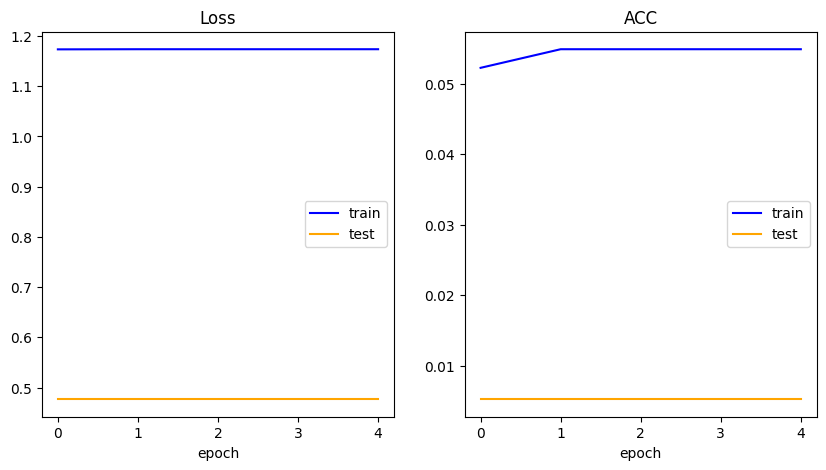

In [30]:
torch.manual_seed(42)


# Initialize the model
model = CustomNet(num_classes=16, weights=True)
#model.freeze_feature_layers()
# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Define metrics (e.g., accuracy)
metrics = {'ACC': accuracy}
# Define Mean Squared Error (MSE) criterion
criterion = nn.MSELoss()


N_EPOCHS = 5


train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics,  n_epochs=N_EPOCHS)

# save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'base_model.pth')